# LSTM - Time Series 


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


# 1. Colab File Upload

In [3]:
url =  'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# 2. Data Preprocessing

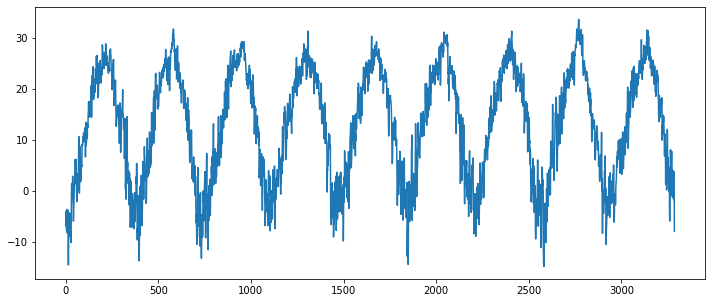

In [5]:
# 일일 평균 온도('avg') 변화 시각화

# 패턴 확인

temp_data = temp[['avg']]
plt.figure(figsize=(12,5))
plt.plot(temp_data)
plt.show()

In [6]:
# Normalization
# tanh activation을 위해 -1~1로 정규화

scaler = MinMaxScaler(feature_range=(-1,1))

temp_data = scaler.fit_transform(temp_data)

In [7]:
# train, test split
# train = 2011.01.01 - 2017.12.31
# test = 2018.01.01 - 2019.12.31

train = temp_data[0:2557]
test = temp_data[2557:]

# 3. 시계열 데이터 처리 함수

In [9]:
# 시계열 학습용 데이터 생성 함수 정의

def create_dataset(time_data, look_back =1):
    data_x, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_x.append(time_data[i:(i+look_back),0])
        data_y.append(time_data[i+ look_back, 0])

    return np.array(data_x), np.array(data_y)

In [10]:
# loop_back 기간 설정 후 학습데이터 생성

look_back = 180

train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [11]:
# tensor reshape

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1],1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# 4. LSTM Modeling

In [12]:
# Model define

model = Sequential(name = 'LSTM')
model.add(LSTM(64,
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

In [13]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
# model compile

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam')

In [15]:
# model fit

%%time

hist = model.fit(train_x, train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (test_x, test_y))

Epoch 1/200
149/149 [==============================] - 13s 39ms/step - loss: 0.0240 - val_loss: 0.0145
Epoch 2/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0156 - val_loss: 0.0145
Epoch 3/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0138 - val_loss: 0.0112
Epoch 4/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 5/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 6/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0098 - val_loss: 0.0088
Epoch 7/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 8/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 9/200
149/149 [==============================] - 5s 36ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 10/200
149/149 [==============================] - 5s 36ms/step - loss: 0.00

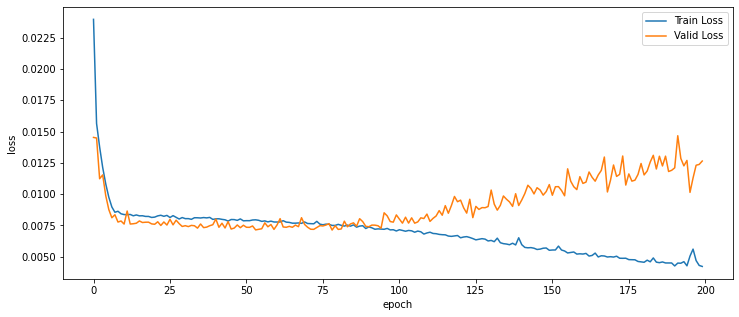

In [16]:
# visualization

plt.figure(figsize = (12,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()

In [18]:
# model evaluate

trainScore = model.evaluate(train_x, train_y, verbose = 0)
print('Train Score : ', trainScore)

testScore = model.evaluate(test_x, test_y, verbose = 0)
print('Test Score : ', testScore)


Train Score :  0.003822839120402932
Test Score :  0.012643071822822094


# 5. Model Predict

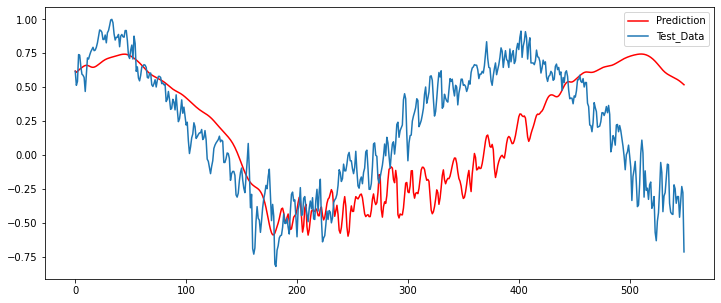

In [20]:
look_ahead = 550

xhat = test_x[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')
plt.legend()
plt.show()

# THE END